## Import Libraries

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.optimize import minimize
from datetime import datetime

In [2]:
pd.set_option('display.max_columns', None) #displays all columns

## Data Loading & Processing

In [3]:
match_data = pd.read_csv('matches.csv')   # match data 
match_data.head()                         # print first 5 rows

,key_id,tournament_id,tournament_name,match_id,match_name,stage_name,group_name,group_stage,knockout_stage,replayed,replay,match_date,match_time,stadium_id,stadium_name,city_name,country_name,home_team_id,home_team_name,home_team_code,away_team_id,away_team_name,away_team_code,score,home_team_score,away_team_score,home_team_score_margin,away_team_score_margin,extra_time,penalty_shootout,score_penalties,home_team_score_penalties,away_team_score_penalties,result,home_team_win,away_team_win,draw
0,1,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,group stage,Group 1,1,0,0,0,1930-07-13,15:00,S-240,Estadio Pocitos,Montevideo,Uruguay,T-30,France,FRA,T-46,Mexico,MEX,4–1,4,1,3,-3,0,0,0-0,0,0,home team win,1,0,0
1,2,WC-1930,1930 FIFA Men's World Cup,M-1930-02,United States vs Belgium,group stage,Group 4,1,0,0,0,1930-07-13,15:00,S-239,Estadio Gran Parque Central,Montevideo,Uruguay,T-83,United States,USA,T-06,Belgium,BEL,3–0,3,0,3,-3,0,0,0-0,0,0,home team win,1,0,0
2,3,WC-1930,1930 FIFA Men's World Cup,M-1930-03,Yugoslavia vs Brazil,group stage,Group 2,1,0,0,0,1930-07-14,12:45,S-239,Estadio Gran Parque Central,Montevideo,Uruguay,T-87,Yugoslavia,YUG,T-09,Brazil,BRA,2–1,2,1,1,-1,0,0,0-0,0,0,home team win,1,0,0
3,4,WC-1930,1930 FIFA Men's World Cup,M-1930-04,Romania vs Peru,group stage,Group 3,1,0,0,0,1930-07-14,14:50,S-240,Estadio Pocitos,Montevideo,Uruguay,T-61,Romania,ROU,T-56,Peru,PER,3–1,3,1,2,-2,0,0,0-0,0,0,home team win,1,0,0
4,5,WC-1930,1930 FIFA Men's World Cup,M-1930-05,Argentina vs France,group stage,Group 1,1,0,0,0,1930-07-15,16:00,S-239,Estadio Gran Parque Central,Montevideo,Uruguay,T-03,Argentina,ARG,T-30,France,FRA,1–0,1,0,1,-1,0,0,0-0,0,0,home team win,1,0,0


In [4]:
rank_data = pd.read_csv('fifa_ranking-2024-06-20.csv')   # ranking data
rank_data.head()                                         # print first 5 rows

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,140.0,Brunei Darussalam,BRU,2.0,0.0,140,AFC,1992-12-31
1,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31
2,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31
3,31.0,Greece,GRE,38.0,0.0,31,UEFA,1992-12-31
4,30.0,Algeria,ALG,39.0,0.0,30,CAF,1992-12-31


In [5]:
#match_data.columns
match_data = match_data[['key_id', 'tournament_id', 'tournament_name','match_name',
                       'knockout_stage', 'match_date','home_team_name', 'away_team_name',
                       'score', 'home_team_score', 'away_team_score', 'result', 'home_team_win', 'away_team_win','draw']]    #selecting relevant columns

In [6]:
match_data = match_data[match_data['tournament_name'].str.contains("FIFA Men's World Cup", case=False, na=False)]  # extracting only mens data 

In [7]:
#checking for null values
match_data.isnull().sum().sum()  

0

## Exploratory Data Analysis (EDA)

In [8]:
match_data.describe()

,key_id,knockout_stage,home_team_score,away_team_score,home_team_win,away_team_win,draw
count,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000
mean,556.665975,0.255187,1.766598,1.054979,0.565353,0.248963,0.185685
std,364.323630,0.436192,1.601040,1.071720,0.495968,0.432637,0.389054
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,508.500000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,871.250000,1.000000,3.000000,2.000000,1.000000,0.000000,0.000000
max,1248.000000,1.000000,10.000000,7.000000,1.000000,1.000000,1.000000


In [9]:

# Convert match_date to datetime
match_data['match_date'] = pd.to_datetime(match_data['match_date'])

In [10]:


# Basic Summary
print("Total Matches:", match_data.shape[0])
print("Total Teams Involved:", len(set(match_data['home_team_name']).union(set(match_data['away_team_name']))))



Total Matches: 964
Total Teams Involved: 85


C:\Users\mi\AppData\Local\Temp\ipykernel_32012\3356462584.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=['Home Wins', 'Away Wins', 'Draws'], y=[home_wins, away_wins, draws], palette="viridis")


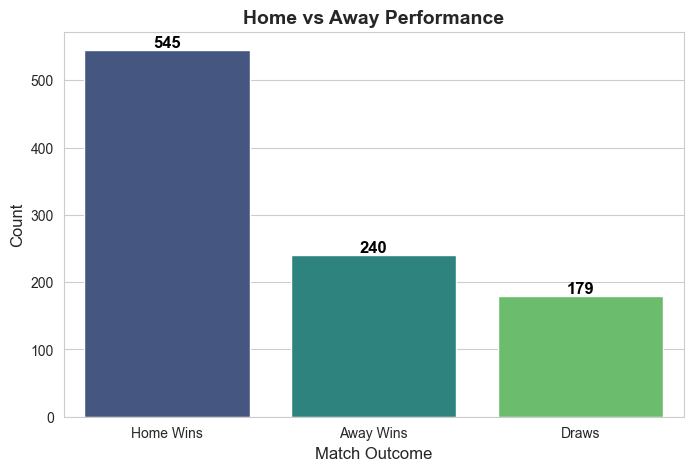

In [11]:

# Set a different Seaborn background style for better visuals
sns.set_style("whitegrid")

# Home vs Away Performance with Annotations
home_wins = match_data['home_team_win'].sum()
away_wins = match_data['away_team_win'].sum()
draws = match_data['draw'].sum()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=['Home Wins', 'Away Wins', 'Draws'], y=[home_wins, away_wins, draws], palette="viridis")

# Annotate each bar with values
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title("Home vs Away Performance", fontsize=14, fontweight='bold')
plt.ylabel("Count", fontsize=12)
plt.xlabel("Match Outcome", fontsize=12)
plt.savefig("home_away_performance_annotated.png", dpi=300)
plt.show()



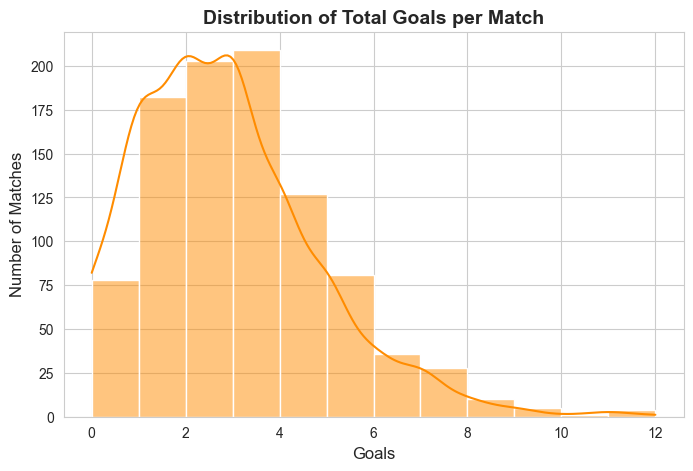

In [12]:
# Average Goals per Match - Improved Distribution Plot
match_data['total_goals'] = match_data['home_team_score'] + match_data['away_team_score']

plt.figure(figsize=(8, 5))
ax = sns.histplot(match_data['total_goals'], bins=range(0, max(match_data['total_goals'])+1), kde=True, color="darkorange")

plt.title("Distribution of Total Goals per Match", fontsize=14, fontweight='bold')
plt.xlabel("Goals", fontsize=12)
plt.ylabel("Number of Matches", fontsize=12)
plt.savefig("Distribution of Total Goals per Match.png", dpi=300)

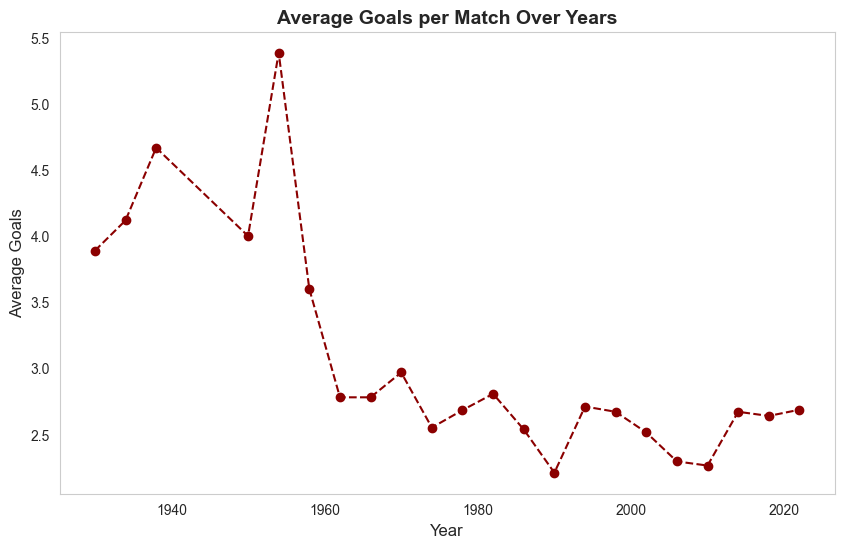

In [13]:
# Performance Over Time with Trend Line
plt.figure(figsize=(10, 6))
ax = match_data.groupby(match_data['match_date'].dt.year)['total_goals'].mean().plot(marker='o', color="darkred", linestyle='dashed')

plt.title("Average Goals per Match Over Years", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Goals", fontsize=12)
plt.grid()
plt.savefig("Average Goals per Match Over Years.png", dpi=300)


In [16]:
# Code to calculate Germany's wins, losses and draws in all FIFA macthes
# Define the team name
team_name = "Germany"

# Calculate wins
wins = ((match_data['home_team_name'] == team_name) & (match_data['home_team_win'] == 1)).sum() + \
       ((match_data['away_team_name'] == team_name) & (match_data['away_team_win'] == 1)).sum()

# Calculate losses
losses = ((match_data['home_team_name'] == team_name) & (match_data['away_team_win'] == 1)).sum() + \
         ((match_data['away_team_name'] == team_name) & (match_data['home_team_win'] == 1)).sum()

draws = ((match_data['home_team_name'] == team_name) | 
         (match_data['away_team_name'] == team_name)) & (match_data['draw'] == 1)

draws = draws.sum()

In [17]:
# Print results
print(f"Germany Wins: {wins}")
print(f"Germany Losses: {losses}")
print(f"Germany Draws: {draws}")

Germany Wins: 33
Germany Losses: 11
Germany Draws: 6


C:\Users\mi\AppData\Local\Temp\ipykernel_32012\4135959714.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


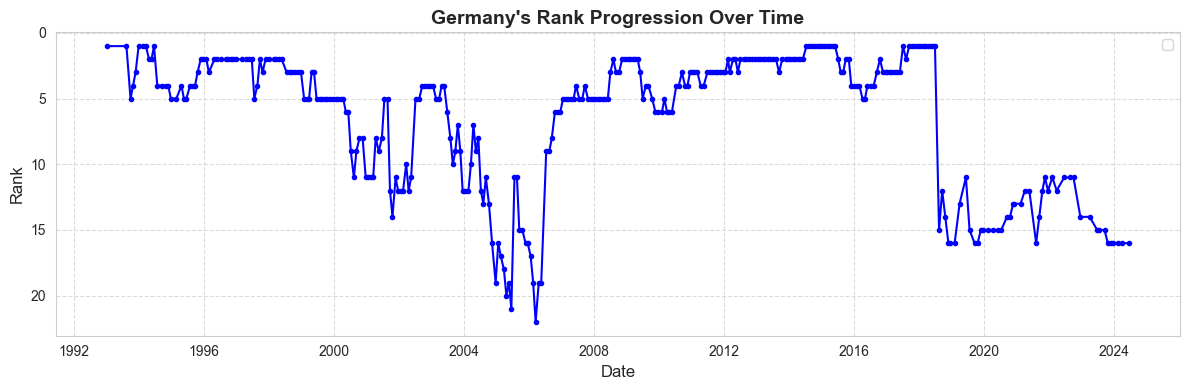

In [18]:
#Code to plot the Germany's ranking over the time 
# Convert rank_date to datetime if it's not already
rank_data['rank_date'] = pd.to_datetime(rank_data['rank_date'])

# Filter Germany's ranking data
germany_rank = rank_data[rank_data['country_full'] == 'Germany'].reset_index(drop=True)

# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(germany_rank['rank_date'], germany_rank['rank'], marker='.', linestyle='-', color='b')

# Customizing the plot
plt.title("Germany's Rank Progression Over Time", fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rank', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis because lower rank values are better
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("germany_rank_progression.png", dpi=300)
plt.show()


## Data Splitting and Time Weight Calculation

In [19]:
# Splits the data into train & test data and then calculate the time weight for each match
# Convert 'match_date' to datetime if not already done
match_data['match_date'] = pd.to_datetime(match_data['match_date'])

# Step 1: Sort the data by match date
match_data = match_data.sort_values(by='match_date')

# Step 2: Calculate the 80-20 split index
split_index = int(len(match_data) * 0.8) 

# Step 3: Split the data into training and testing sets
train_data = match_data.iloc[:split_index]
test_data = match_data.iloc[split_index:]

# Step 4: Define half_period and function to calculate time weights
half_period = 390

def calculate_time_weights(group):
    # Find the most recent match date in the subset
    most_recent_date = group['match_date'].max()
    # Calculate days since each match
    group['days_since_match'] = (most_recent_date - group['match_date']).dt.days
    # Apply the time weight formula
    group['time_weight'] = (1 / 2) ** (group['days_since_match'] / half_period)
    return group
 
# Step 5: Calculate time weights for train and test data separately
train_data = train_data.groupby('home_team_name').apply(calculate_time_weights)
test_data = test_data.groupby('home_team_name').apply(calculate_time_weights)

# Output results
print("Training Data:")
print(train_data.shape)
print("\nTesting Data:")
print(test_data.shape)

Training Data:
(771, 18)

Testing Data:
(193, 18)


C:\Users\mi\AppData\Local\Temp\ipykernel_32012\1274985638.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('home_team_name').apply(calculate_time_weights)
C:\Users\mi\AppData\Local\Temp\ipykernel_32012\1274985638.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = test_data.groupby('home_team_name').apply(calculate_time_weights)


In [20]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

## Bivariate Poisson Model for Match Prediction 

In [21]:
"""
Bivariate Poisson Model for Soccer Match Outcomes

This script implements a bivariate Poisson model to estimate team-specific scoring rates 
for home and away matches, as well as a common dependency factor. The model parameters 
are optimized using maximum likelihood estimation.

"""

# Start time tracking for performance measurement
start = datetime.now()

def bivariate_poisson_likelihood(params, data):
    """
    Computes the negative log-likelihood of the bivariate Poisson distribution for match outcomes.
    
    Parameters:
    - params (list): Model parameters, including scoring rates for each team (home & away) and a common dependency factor.
    - data (DataFrame): Match dataset containing teams, scores, and time-based weightings.

    Returns:
    - float: Negative log-likelihood value to be minimized.
    """
    
    # Number of unique teams
    n_teams = len(teams)
    
    # Assign estimated parameters for each team
    lambda_home = {team: params[i] for i, team in enumerate(teams)}  # Home scoring rate
    lambda_away = {team: params[i + n_teams] for i, team in enumerate(teams)}  # Away scoring rate
    lambda_common = params[-1]  # Common dependency factor across all matches
    
    log_likelihood = 0  # Initialize log-likelihood accumulator
    
    # Iterate through each match record
    for _, row in data.iterrows():
        team_home = row['home_team_name']
        team_away = row['away_team_name']
        goals_home = row['home_team_score']
        goals_away = row['away_team_score']
        time_weight = row['time_weight']  # Weight assigned based on time decay

        # Retrieve Poisson distribution parameters for home and away teams
        lambda_i = lambda_home[team_home]  # Expected home team goals
        lambda_j = lambda_away[team_away]  # Expected away team goals
        lambda_c = lambda_common  # Common dependency parameter (captures correlation in goal-scoring)

        # Compute the joint probability of the observed goal outcomes
        p = sum(
            poisson.pmf(goals_home - k, lambda_i) *  # Probability of home goals minus k
            poisson.pmf(goals_away - k, lambda_j) *  # Probability of away goals minus k
            poisson.pmf(k, lambda_c)  # Probability of k common goals
            for k in range(min(goals_home, goals_away) + 1)  # Summing over common goal contributions
        )
        
        # Accumulate weighted log-likelihood (avoid log(0) issues)
        if p > 0:
            log_likelihood += time_weight * np.log(p)  # Time-weighted log probability
    
    return -log_likelihood  # Return negative value for minimization (since we minimize in optimization)

# Ensure match_data is properly defined
if 'match_data' not in locals() or 'train_data' not in locals():
    raise ValueError("Error: match_data or train_data is not defined. Please load the dataset.")

# Identify unique teams from the dataset
teams = list(set(match_data['home_team_name']).union(set(match_data['away_team_name'])))

# Initial guess for parameters: 
# - Each team gets an estimated home and away scoring rate
# - One additional parameter for the common dependency
initial_params = [1.0] * (len(teams) * 2) + [0.5]  # Initial values for optimization

# Define parameter constraints to ensure all values are positive (Poisson rates must be ≥ 0)
bounds = [(0, None)] * len(initial_params)

# Optimize model parameters using the L-BFGS-B method
result = minimize(
    bivariate_poisson_likelihood,  # Function to minimize
    initial_params,                 # Initial parameter estimates
    args=(train_data,),              # Additional arguments (training data)
    bounds=bounds,                    # Constraints to enforce non-negative rates
    method='L-BFGS-B'                 # Optimization algorithm
)

# Extract optimized parameter values
optimized_params = result.x

# Store optimized team-specific scoring rates
lambda_home = {team: optimized_params[i] for i, team in enumerate(teams)}  # Final home goal rates
lambda_away = {team: optimized_params[i + len(teams)] for i, team in enumerate(teams)}  # Final away goal rates
lambda_common = optimized_params[-1]  # Optimized common dependency parameter

# Measure and display model training duration
end = datetime.now()
print(f"Model training completed in: {end - start}")

Model training completed in: 1:05:15.567082


In [22]:
# Display results
print("Home Strengths:", lambda_home)
print("Away Strengths:", lambda_away)
print("Common Dependency (λC):", lambda_common)

Home Strengths: {'New Zealand': 0.782969186108555, 'Romania': 0.6263248930925204, 'Spain': 1.1424870682436712, 'Ghana': 0.2555335878564306, 'Morocco': 1.1054292413973836, 'Russia': 1.5930781991386829, 'Turkey': 2.060834645539973, 'Denmark': 0.6001928920545071, 'Germany': 2.048435444904735, 'Ecuador': 1.5035562959035786, 'Republic of Ireland': 0.7667308154627283, 'Austria': 0.7087296582229303, 'Saudi Arabia': 0.0, 'North Korea': 0.287138707920882, 'El Salvador': 1.0, 'South Korea': 1.599859575196801, 'Trinidad and Tobago': 0.2871387079809299, 'China': 0.287138707994744, 'Croatia': 1.0507349540430577, 'Slovenia': 0.4672858593681748, 'Soviet Union': 0.6585189382878273, 'Togo': 0.0, 'United States': 0.6975532871989504, 'Bulgaria': 2.2853239646361443, 'Wales': 1.324456844183062, 'Netherlands': 1.7937344640941861, 'Canada': 0.2871387113467467, 'Angola': 0.2871387079855318, 'Peru': 0.4630038701620262, 'Iceland': 1.0, 'Cameroon': 0.4230228193494861, 'Zaire': 0.0, 'Serbia and Montenegro': 0.287

## Match Outcome Prediction

In [23]:
def predict_bivariate_poisson(lambda_home, lambda_away, lambda_common, test_data):
    """
    Predicts the most likely soccer match scores using the trained Bivariate Poisson model.

    Parameters:
    - lambda_home (dict): Dictionary containing estimated home scoring rates for each team.
    - lambda_away (dict): Dictionary containing estimated away scoring rates for each team.
    - lambda_common (float): Estimated common dependency factor affecting goal-scoring.
    - test_data (DataFrame): Test dataset.

    Returns:
    - list: A list of dictionaries containing predicted scores for each match.
    """

    predictions = []  # List to store match predictions

    # Iterate through test matches
    for _, row in test_data.iterrows():
        team_home = row['home_team_name']
        team_away = row['away_team_name']

        # Retrieve the optimized Poisson parameters for the teams
        lambda_i = lambda_home[team_home]  # Home team expected goals
        lambda_j = lambda_away[team_away]  # Away team expected goals
        lambda_c = lambda_common           # Common dependency factor

        # Initialize probability matrix for goal distributions (assuming max score range 0-9)
        prob_matrix = np.zeros((10, 10))  

        # Compute probabilities for all possible score outcomes (0-9 goals for both teams)
        for goals_home in range(10):
            for goals_away in range(10):
                p = 0
                # Summing over common goal contributions to get joint probability
                for k in range(min(goals_home, goals_away) + 1):
                    p += (
                        poisson.pmf(goals_home - k, lambda_i) *  # Home team goal probability
                        poisson.pmf(goals_away - k, lambda_j) *  # Away team goal probability
                        poisson.pmf(k, lambda_c)  # Shared goal probability
                    )
                prob_matrix[goals_home, goals_away] = p  # Store probability of (goals_home, goals_away)

        # Determine the most likely score outcome
        most_likely_score = np.unravel_index(prob_matrix.argmax(), prob_matrix.shape)

        # Store prediction results
        predictions.append({
            'home_team': team_home,
            'away_team': team_away,
            'predicted_home_score': most_likely_score[0],
            'predicted_away_score': most_likely_score[1],
            'prob_matrix': prob_matrix  # Optional: For further analysis
        })
    
    return predictions

# Predict on the test dataset
test_predictions = predict_bivariate_poisson(lambda_home, lambda_away, lambda_common, test_data)

# Convert predictions into a Pandas DataFrame for better readability
test_predictions_df = pd.DataFrame(test_predictions)

# Display the first few predictions
print(test_predictions_df[['home_team', 'away_team', 'predicted_home_score', 'predicted_away_score']])

     home_team               away_team  predicted_home_score  \
0      Algeria                  Russia                     0   
1    Argentina  Bosnia and Herzegovina                     2   
2    Argentina                    Iran                     2   
3    Argentina             Switzerland                     2   
4    Argentina                 Belgium                     2   
..         ...                     ...                   ...   
188    Uruguay                Portugal                     0   
189    Uruguay                  France                     0   
190    Uruguay             South Korea                     0   
191      Wales                    Iran                     1   
192      Wales                 England                     1   

     predicted_away_score  
0                       1  
1                       1  
2                       0  
3                       1  
4                       1  
..                    ...  
188                     0  
189    

## Model Evaluation: Rank Probability Score (RPS)

In [28]:
#calculate RPS score for the test data
# Add actual binary outcomes to the test data
test_data['y_Hm'] = (test_data['home_team_score'] > test_data['away_team_score']).astype(int)  # 1 if home team wins
test_data['y_Am'] = (test_data['away_team_score'] > test_data['home_team_score']).astype(int)  # 1 if away team wins

# Predicted probabilities (ensuring probabilities are within [0,1])
# Assuming predicted scores are proportional to winning probabilities
test_data['P_Hm'] = test_predictions_df['predicted_home_score'] / (
    test_predictions_df['predicted_home_score'] + test_predictions_df['predicted_away_score']
)
test_data['P_Am'] = test_predictions_df['predicted_away_score'] / (
    test_predictions_df['predicted_home_score'] + test_predictions_df['predicted_away_score']
)

# Calculate the Rank Probability Score (RPS) for each match
test_data['RPS'] = (
    (test_data['P_Hm'] - test_data['y_Hm']) ** 2 +  # Squared difference for home team probability
    (test_data['P_Am'] - test_data['y_Am']) ** 2    # Squared difference for away team probability
) / (2 * len(test_data))  # Divide by 2M as per the formula

# Compute the mean RPS over all matches
mean_rps = test_data['RPS'].sum()  # Summing over all matches

# Display the final Rank Probability Score
print(f"Mean Rank Probability Score (RPS): {mean_rps:.4f}")

Mean Rank Probability Score (RPS): 0.2339


## Calculated Germany’s Ranking  vs. Actual FIFA Rankings

In [29]:
# Merge predictions with actual scores from test data
comparison_df = test_data.copy()
comparison_df['predicted_home_score'] = test_predictions_df['predicted_home_score']
comparison_df['predicted_away_score'] = test_predictions_df['predicted_away_score']
# Calculate errors
comparison_df['home_score_error'] = abs(comparison_df['home_team_score'] - comparison_df['predicted_home_score'])
comparison_df['away_score_error'] = abs(comparison_df['away_team_score'] - comparison_df['predicted_away_score'])

In [86]:
#creatin prediction column needed for calculating the ranking
def determine_winner(row):
    if row['predicted_home_score'] > row['predicted_away_score']:
        return 'home team win'
    elif row['predicted_home_score'] < row['predicted_away_score']:
        return 'away team win'
    else:
        return "draw"

# Apply the function to determine the winner for each match
comparison_df['prediction'] = comparison_df.apply(determine_winner, axis=1)

In [87]:
# Filtering only Germany matches from the test data to compare the rank with the actual.
germany_data = comparison_df[(comparison_df['home_team_name']=='Germany') | (comparison_df['away_team_name']=='Germany')]
germany_data  = germany_data.sort_values(by='match_date', ascending=True).reset_index(drop=True)

In [88]:
germany_data = germany_data.rename(columns = {'result':'actual'})

In [94]:
germany_data[[ 'match_date', 'home_team_name', 'away_team_name',
       'score',  'actual','predicted_home_score', 'predicted_away_score',
        'prediction', 'germany_status']]

,match_date,home_team_name,away_team_name,score,actual,predicted_home_score,predicted_away_score,prediction,germany_status
0,2014-06-16,Germany,Portugal,4–0,home team win,2,0,home team win,Win
1,2014-06-21,Germany,Ghana,2–2,draw,2,1,home team win,Win
2,2014-06-26,United States,Germany,0–1,away team win,0,2,away team win,Win
3,2014-06-30,Germany,Algeria,2–1,home team win,2,0,home team win,Win
4,2014-07-04,France,Germany,0–1,away team win,0,2,away team win,Win
5,2014-07-08,Brazil,Germany,1–7,away team win,2,2,draw,Draw
6,2014-07-13,Germany,Argentina,1–0,home team win,2,1,home team win,Win
7,2018-06-17,Germany,Mexico,0–1,away team win,2,0,home team win,Win
8,2018-06-23,Germany,Sweden,2–1,home team win,2,0,home team win,Win
9,2018-06-27,South Korea,Germany,2–0,home team win,1,2,away team win,Win


In [95]:
# Function to determine Germany's match result
def get_germany_status(row):

    if row["prediction"] == "home team win" and row["home_team_name"] == "Germany":
        return "Win"
    elif row["prediction"] == "away team win" and row["away_team_name"] == "Germany":
        return "Win"
    elif row["prediction"] == "draw":
        return "Draw"
    else:
        return "Defeat"


# Apply function to create new column
germany_data["germany_status"] =germany_data.apply(get_germany_status, axis=1)

In [96]:

germany_data[['match_date', 'home_team_name', 'away_team_name',
       'score', 
        'predicted_home_score', 'predicted_away_score','actual','prediction','germany_status']]

,match_date,home_team_name,away_team_name,score,predicted_home_score,predicted_away_score,actual,prediction,germany_status
0,2014-06-16,Germany,Portugal,4–0,2,0,home team win,home team win,Win
1,2014-06-21,Germany,Ghana,2–2,2,1,draw,home team win,Win
2,2014-06-26,United States,Germany,0–1,0,2,away team win,away team win,Win
3,2014-06-30,Germany,Algeria,2–1,2,0,home team win,home team win,Win
4,2014-07-04,France,Germany,0–1,0,2,away team win,away team win,Win
5,2014-07-08,Brazil,Germany,1–7,2,2,away team win,draw,Draw
6,2014-07-13,Germany,Argentina,1–0,2,1,home team win,home team win,Win
7,2018-06-17,Germany,Mexico,0–1,2,0,away team win,home team win,Win
8,2018-06-23,Germany,Sweden,2–1,2,0,home team win,home team win,Win
9,2018-06-27,South Korea,Germany,2–0,1,2,home team win,away team win,Win


In [97]:
"""Match date from the test data and the rank_date from the rank_data are different so Finding the closest rank date and the rank of the Germany team 
which will be the starting to calulate the ranking based on the model prediction"""

# Dates to find closest past ranks for
target_dates = [pd.to_datetime("2014-06-16"), pd.to_datetime("2018-06-17"),pd.to_datetime("2022-12-01")]

# Function to find the closest previous rank date
def find_closest_previous_rank(date, rank_df):
    previous_ranks = rank_df[rank_df['rank_date'] < date]
    if not previous_ranks.empty:
        closest_date = previous_ranks['rank_date'].max()
        closest_rank = previous_ranks.loc[previous_ranks['rank_date'] == closest_date, 'rank'].values[0]
        return closest_date, closest_rank
    return None, None

# Find closest previous rank dates and ranks
closest_ranks = {date: find_closest_previous_rank(date, germany_rank) for date in target_dates}

closest_ranks


{Timestamp('2014-06-16 00:00:00'): (Timestamp('2014-06-05 00:00:00'), 2.0),
 Timestamp('2018-06-17 00:00:00'): (Timestamp('2018-06-07 00:00:00'), 1.0),
 Timestamp('2022-12-01 00:00:00'): (Timestamp('2022-10-06 00:00:00'), 11.0)}

In [108]:
def get_closest_rank(opponent, match_date, rank_data):
    """
    Find the closest available ranking of the opponent before the match.
    """
    rank_data['rank_date'] = pd.to_datetime(rank_data['rank_date'])
    closest_rank = rank_data[(rank_data['country_full'] == opponent) & (rank_data['rank_date'] <= match_date)]
    if not closest_rank.empty:
        return closest_rank.sort_values(by='rank_date', ascending=False).iloc[0]['rank']
    return np.nan  # If no rank data is found

def calculate_new_ranking(prev_rank, match_result, match_importance, opponent_rank, confed_coeff=0.85):
    """
    Adjusts Germany's ranking after each match based on FIFA's 2006-2018 ranking formula.
    """
    # Match Result Factor (M)
    result_points = {'Win': 3, 'Draw': 1, 'Defeat': 0} 
    M = result_points.get(match_result, 0)
    
    # Importance Factor (I) - Already included correctly
    I = match_importance  

    # Opponent Strength Factor (T)
    T = (200 - opponent_rank) / 100 if opponent_rank < 200 else 0.50

    # Confederation Coefficient (C)
    C = confed_coeff  # Should be between 0.85 - 1.0

    # FIFA Formula: P = M × I × T × C × 100
    P = M * I * T * C * 100
    
    # Update ranking (Lower is better)
    new_rank = prev_rank - (P / 1000)  # Scale factor to prevent extreme changes
    
    return round(max(1, new_rank), 0)  # Ranking cannot be less than 1



# Initial FIFA ranking before FIFA 2014
germany_initial_rank = 2.0

# Match importance factor for FIFA World Cup matches
match_importance = 4.0

# Placeholder for opponent rankings
germany_data['opponent_rank'] = np.nan

germany_data['year'] = germany_data['match_date'].dt.year

# Assign opponent ranks dynamically
for index, row in germany_data.iterrows():
    opponent = row['home_team_name'] if row['away_team_name'] == 'Germany' else row['away_team_name']
    germany_data.at[index, 'opponent_rank'] = get_closest_rank(opponent, row['match_date'], rank_data)

# Compute updated rankings
current_ranking = germany_initial_rank
germany_data['calculated_ranking'] = np.nan

for index, row in germany_data.iterrows():
    current_ranking = calculate_new_ranking(
        prev_rank=current_ranking,
        match_result=row['germany_status'],
        match_importance=match_importance,
        opponent_rank=row['opponent_rank']
    )
    germany_data.at[index, 'calculated_ranking'] = current_ranking

In [115]:
germany_data[['match_date', 'home_team_name', 'away_team_name', 'actual','prediction','calculated_ranking']]

,match_date,home_team_name,away_team_name,actual,prediction,calculated_ranking
0,2014-06-16,Germany,Portugal,home team win,home team win,1.0
1,2014-06-21,Germany,Ghana,draw,home team win,1.0
2,2014-06-26,United States,Germany,away team win,away team win,1.0
3,2014-06-30,Germany,Algeria,home team win,home team win,1.0
4,2014-07-04,France,Germany,away team win,away team win,1.0
5,2014-07-08,Brazil,Germany,away team win,draw,1.0
6,2014-07-13,Germany,Argentina,home team win,home team win,1.0
7,2018-06-17,Germany,Mexico,away team win,home team win,1.0
8,2018-06-23,Germany,Sweden,home team win,home team win,1.0
9,2018-06-27,South Korea,Germany,home team win,away team win,1.0


In [ ]:
# To plot the comparison between calculated ranking and fifa ranking merging the germany_data and rank_data

In [110]:


germany_data['match_date'] = pd.to_datetime(germany_data['match_date'])
germany_rank['rank_date'] = pd.to_datetime(germany_rank['rank_date'])

# Step 1: Extract min and max dates from germany_data
min_date = germany_data['match_date'].min()
max_date = germany_data['match_date'].max()

# Step 2: Find the closest dates in germany_rank for min and max
closest_min_date = germany_rank.loc[(germany_rank['rank_date'] - min_date).abs().idxmin(), 'rank_date']
closest_max_date = germany_rank.loc[(germany_rank['rank_date'] - max_date).abs().idxmin(), 'rank_date']

# Step 3: Filter germany_rank within the closest date range
filtered_germany_rank = germany_rank[
    (germany_rank['rank_date'] >= closest_min_date) & (germany_rank['rank_date'] <= closest_max_date)
]

In [116]:
merged_data 

,match_date,calculated_ranking,rank,year
0,2014-06-16,1.0,2.0,2014
1,2014-06-21,1.0,2.0,2014
2,2014-06-26,1.0,2.0,2014
3,2014-06-30,1.0,2.0,2014
4,2014-07-04,1.0,2.0,2014
5,2014-07-08,1.0,2.0,2014
6,2014-07-13,1.0,2.0,2014
7,2018-06-17,1.0,1.0,2018
8,2018-06-23,1.0,1.0,2018
9,2018-06-27,1.0,1.0,2018


C:\Users\mi\AppData\Local\Temp\ipykernel_32012\1476471979.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_germany_rank['rank_date'] = pd.to_datetime(filtered_germany_rank['rank_date'])


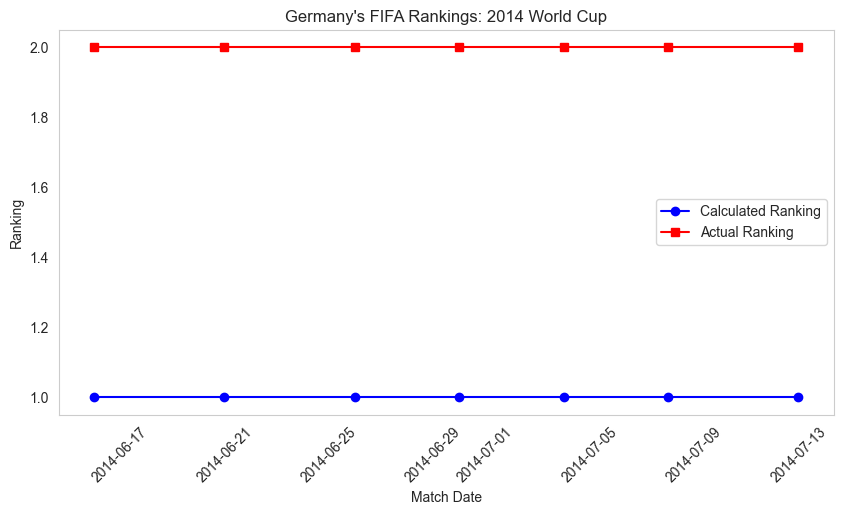

In [113]:
# Set Seaborn style
sns.set_style("whitegrid")

# Convert date columns to datetime format
germany_data['match_date'] = pd.to_datetime(germany_data['match_date'])
filtered_germany_rank['rank_date'] = pd.to_datetime(filtered_germany_rank['rank_date'])

# Merge both datasets on the closest available date
merged_data = pd.merge_asof(
    germany_data.sort_values('match_date'),
    filtered_germany_rank.sort_values('rank_date'),
    left_on='match_date',
    right_on='rank_date',
    direction='backward'
)

# Extract relevant columns for plotting
merged_data = merged_data[['match_date', 'calculated_ranking', 'rank']]
merged_data['year'] = merged_data['match_date'].dt.year

# Filter for 2014 only
year_data = merged_data[merged_data['year'] == 2014]

# Plot comparison for 2014 FIFA World Cup
plt.figure(figsize=(10, 5))
plt.plot(year_data['match_date'], year_data['calculated_ranking'], marker='o', linestyle='-', label='Calculated Ranking', color='blue')
plt.plot(year_data['match_date'], year_data['rank'], marker='s', linestyle='-', label='Actual Ranking', color='red')

# Formatting
plt.xlabel('Match Date')
plt.ylabel('Ranking')
plt.title("Germany's FIFA Rankings: 2014 World Cup")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Save figure
plt.savefig('germany_ranking_2014.png', dpi=300, bbox_inches='tight')
plt.show()
